In [4]:
import numpy as np
import pandas as pd
import ta
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from ta import add_all_ta_features
from ta import momentum
from ta.utils import dropna

In [5]:
#pip install xgboost

In [6]:
def get_data(company_symbol):
    return pd.read_csv("dataset/"+company_symbol+".csv")

In [7]:
data = get_data("NFLX")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,5/23/2002,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,5/24/2002,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,5/28/2002,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,5/29/2002,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,5/30/2002,1.107857,1.107857,1.071429,1.071429,1.071429,10154200
...,...,...,...,...,...,...,...
4890,10/25/2021,663.739990,675.880005,657.070007,671.659973,671.659973,3833500
4891,10/26/2021,673.760010,676.489990,662.770020,668.520020,668.520020,2904800
4892,10/27/2021,669.000000,671.409973,661.849976,662.919983,662.919983,2276900
4893,10/28/2021,670.950012,676.799988,668.030029,674.049988,674.049988,2859400


In [8]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
data.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [10]:
data[data.columns[data.isna().any()]]

""
0
1
2
3
4
...
4890
4891
4892
4893


In [11]:
cond1 = data.Date.isna() # aapl['Date'].isna()
cond2 = data.Date.str.contains(r'^\s*$', na=False)
cond3 = data.Date == ''

data_checked = data.assign(cond1= cond1, cond2= cond2, cond3= cond3)
print (data_checked)

            Date        Open        High         Low       Close   Adj Close  \
0      5/23/2002    1.156429    1.242857    1.145714    1.196429    1.196429   
1      5/24/2002    1.214286    1.225000    1.197143    1.210000    1.210000   
2      5/28/2002    1.213571    1.232143    1.157143    1.157143    1.157143   
3      5/29/2002    1.164286    1.164286    1.085714    1.103571    1.103571   
4      5/30/2002    1.107857    1.107857    1.071429    1.071429    1.071429   
...          ...         ...         ...         ...         ...         ...   
4890  10/25/2021  663.739990  675.880005  657.070007  671.659973  671.659973   
4891  10/26/2021  673.760010  676.489990  662.770020  668.520020  668.520020   
4892  10/27/2021  669.000000  671.409973  661.849976  662.919983  662.919983   
4893  10/28/2021  670.950012  676.799988  668.030029  674.049988  674.049988   
4894  10/29/2021  673.059998  690.969971  671.239990  690.309998  690.309998   

         Volume  cond1  cond2  cond3  


In [12]:
def simple_moving_average_5(close):
    return close.rolling(5, min_periods=1).mean()

In [13]:
def simple_moving_average_10(close):
    return close.rolling(10, min_periods=1).mean()

In [14]:
def stochastic_k(high, low, close):
    return (((close-low.rolling(14).min())/(high.rolling(14).max()-low.rolling(14).min()))*100)

In [15]:
def stochastic_d(stochastic_k):
    return stochastic_k.rolling(3,min_periods=1).mean()

In [16]:
def larry_williams_r(high, low, close):
    return (((high.rolling(14).max()-close)/(high.rolling(14).max()-low.rolling(14).min()))*100)

In [17]:
def rate_of_change(close):
    return ((close-close.shift(12))/close.shift(12))

In [18]:
def price_volume_trend(close, volume):
    return (((close-close.shift(1))/close.shift(1))*volume)

In [19]:
def accumulation_distribution_oscillator(high, low, close):
    return((high-close.shift(1))/(high-low))

In [20]:
def weighted_moving_average_10(close):
    return ((10*close+9*close.shift(1)+8*close.shift(2)+7*close.shift(3)
             +6*close.shift(4)+5*close.shift(5)+4*close.shift(6)+3*close.shift(7)
             +2*close.shift(8)+close.shift(9))/(10+9+8+7+6+5+4+3+2+1))

In [21]:
def exponential_moving_average_12(close):
    return (close.ewm(span=12, adjust=False).mean())

In [22]:
def exponential_moving_average_26(close):
    return (close.ewm(span=26, adjust=False).mean())

In [23]:
def moving_average_convergence_divergence(ema_12, ema_26):
    return (ema_12 - ema_26)

In [24]:
def momentum(close):
    return ((close/close.shift(14))*100)

In [25]:
def change(close):
    return (close.shift(-1) - close)

In [26]:
def direction(change):
    return (np.where(change>0, 1, 0))

In [27]:
def relative_strength_index(direction):
    return (100-(100/(1+(direction.rolling(14).sum()/14)/(14-direction.rolling(14).sum())/14)))

In [28]:
def channel_commodity_index(df, ndays): 
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3 
    df['sma'] = df['TP'].rolling(ndays).mean()
    df['mad'] = df['TP'].rolling(ndays).apply(lambda x: pd.Series(x).mad())
    df['CCI'] = (df['TP'] - df['sma']) / (0.015 * df['mad']) 
    return df['CCI']

In [29]:
def disparity_index(close):
    return (((close - close.rolling(14).mean())/(close.rolling(14).mean()))*100)

In [30]:
def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return adx_smooth

In [31]:
def aroon(close):
    return (ta.trend.AroonIndicator(close, 25, True).aroon_indicator())

In [32]:
def compute_all_indicators(data):
    data['SMA5'] = simple_moving_average_5(data['Close'])
    data['SMA10'] = simple_moving_average_10(data['Close'])
    data['StochasticK'] = stochastic_k(data['High'], data['Low'], data['Close'])
    data['StochasticD'] = stochastic_d(data['StochasticK'])
    data['LarryWilliamsR'] = larry_williams_r(data['High'], data['Low'], data['Close'])
    data['ROC'] = rate_of_change(data['Close'])
    data['PVT'] = price_volume_trend(data['Close'], data['Volume'])
    data['ADO'] = accumulation_distribution_oscillator(data['High'], data['Low'], data['Close'])
    data['WMA10'] = weighted_moving_average_10(data['Close'])
    data['EMA12'] = exponential_moving_average_12(data['Close'])
    data['EMA26'] = exponential_moving_average_26(data['Close'])
    data['MACD'] = moving_average_convergence_divergence(data['EMA12'], data['EMA26'])
    data['Momentum'] = momentum(data['Close'])
    data['Change'] = change(data['Close'])
    data['Direction'] = direction(data['Change'])
    data['RSI'] = relative_strength_index(data['Direction'])
    data['CCI'] = channel_commodity_index(data, 14)
    data['DI'] = disparity_index(data['Close'])
    data['ADX'] = get_adx(data['High'], data['Low'], data['Close'], 14)
    data['Aroon'] = aroon(data['Close'])    
    return data

In [33]:
complete_data = compute_all_indicators(data)
complete_data

,Date,Open,High,Low,Close,Adj Close,Volume,SMA5,SMA10,StochasticK,...,Change,Direction,RSI,TP,sma,mad,CCI,DI,ADX,Aroon
0,5/23/2002,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,1.196429,1.196429,NaN,...,0.013571,1,NaN,1.195000,NaN,NaN,NaN,NaN,NaN,0.0
1,5/24/2002,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,1.203215,1.203215,NaN,...,-0.052857,0,NaN,1.210714,NaN,NaN,NaN,NaN,NaN,4.0
2,5/28/2002,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,1.187857,1.187857,NaN,...,-0.053572,0,NaN,1.182143,NaN,NaN,NaN,NaN,NaN,-4.0
3,5/29/2002,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,1.166786,1.166786,NaN,...,-0.032142,0,NaN,1.117857,NaN,NaN,NaN,NaN,NaN,-8.0
4,5/30/2002,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,1.147714,1.147714,NaN,...,0.005000,1,NaN,1.083572,NaN,NaN,NaN,NaN,NaN,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4890,10/25/2021,663.739990,675.880005,657.070007,671.659973,671.659973,3833500,650.747998,640.849994,92.814518,...,-3.139953,0,0.675676,668.203328,637.748567,8.702045,233.314986,5.191655,30.298693,96.0
4891,10/26/2021,673.760010,676.489990,662.770020,668.520020,668.520020,2904800,656.652002,645.207996,86.568968,...,-5.600037,0,0.675676,669.260010,640.187855,11.809801,164.113158,4.356440,30.769399,76.0
4892,10/27/2021,669.000000,671.409973,661.849976,662.919983,662.919983,2276900,664.207996,648.523993,77.131758,...,11.130005,1,0.675676,665.393311,642.260234,13.930309,110.708606,3.125012,31.225713,76.0
4893,10/28/2021,670.950012,676.799988,668.030029,674.049988,674.049988,2859400,668.385999,652.548993,95.389771,...,16.260010,1,0.910010,672.960002,644.916425,16.039255,116.562258,4.376381,31.577094,88.0


In [34]:
complete_data = complete_data.dropna()

In [35]:
complete_data

,Date,Open,High,Low,Close,Adj Close,Volume,SMA5,SMA10,StochasticK,...,Change,Direction,RSI,TP,sma,mad,CCI,DI,ADX,Aroon
14,6/13/2002,1.104286,1.122143,1.080000,1.082857,1.082857,2567600,1.120857,1.125643,7.110768,...,-0.096428,0,0.282646,1.095000,1.135578,0.031001,-87.262252,-4.041967,6.531289,-12.0
15,6/14/2002,1.082143,1.085714,0.980000,0.986429,0.986429,4783800,1.094429,1.116643,2.549744,...,-0.064286,0,0.282646,1.017381,1.121769,0.031939,-217.891706,-11.332225,9.143382,-56.0
16,6/17/2002,1.013571,1.059286,0.917857,0.922143,0.922143,4855200,1.047571,1.096000,1.363726,...,-0.011429,0,0.282646,0.966429,1.106361,0.041992,-222.155602,-15.840926,19.140010,-60.0
17,6/18/2002,0.938571,0.939286,0.842143,0.910714,0.910714,10808000,0.999000,1.075286,17.582308,...,0.040715,1,0.381194,0.897381,1.090612,0.058975,-218.434212,-15.825737,27.026513,-64.0
18,6/19/2002,0.911429,0.996429,0.892857,0.951429,0.951429,5482400,0.970714,1.055714,28.022051,...,0.005714,1,0.381194,0.946905,1.080850,0.071526,-124.845930,-11.360356,33.442196,-64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,10/22/2021,651.809998,665.460022,651.809998,664.780029,664.780029,6179700,644.009998,636.387994,98.839008,...,6.879944,1,0.910010,660.683350,634.831425,5.952110,289.554743,4.545124,30.296476,92.0
4890,10/25/2021,663.739990,675.880005,657.070007,671.659973,671.659973,3833500,650.747998,640.849994,92.814518,...,-3.139953,0,0.675676,668.203328,637.748567,8.702045,233.314986,5.191655,30.298693,96.0
4891,10/26/2021,673.760010,676.489990,662.770020,668.520020,668.520020,2904800,656.652002,645.207996,86.568968,...,-5.600037,0,0.675676,669.260010,640.187855,11.809801,164.113158,4.356440,30.769399,76.0
4892,10/27/2021,669.000000,671.409973,661.849976,662.919983,662.919983,2276900,664.207996,648.523993,77.131758,...,11.130005,1,0.675676,665.393311,642.260234,13.930309,110.708606,3.125012,31.225713,76.0


In [36]:
# data['STO'] = ta.momentum.StochasticOscillator(data["Close"], data["High"], data["Low"], 20, 2, True).stoch()

In [37]:
corrMatrix = complete_data.corr()
print(corrMatrix)

                    Open      High       Low     Close  Adj Close    Volume  \
Open            1.000000  0.999865  0.999862  0.999712   0.999712 -0.253236   
High            0.999865  1.000000  0.999822  0.999871   0.999871 -0.251896   
Low             0.999862  0.999822  1.000000  0.999864   0.999864 -0.254485   
Close           0.999712  0.999871  0.999864  1.000000   1.000000 -0.253072   
Adj Close       0.999712  0.999871  0.999864  1.000000   1.000000 -0.253072   
Volume         -0.253236 -0.251896 -0.254485 -0.253072  -0.253072  1.000000   
SMA5            0.999663  0.999646  0.999587  0.999545   0.999545 -0.253216   
SMA10           0.999111  0.999099  0.999008  0.998969   0.998969 -0.253263   
StochasticK     0.061378  0.062960  0.064589  0.066233   0.066233 -0.029361   
StochasticD     0.068424  0.068316  0.069838  0.069691   0.069691 -0.031845   
LarryWilliamsR -0.061378 -0.062960 -0.064589 -0.066233  -0.066233  0.029361   
ROC            -0.009579 -0.009069 -0.008351 -0.0077

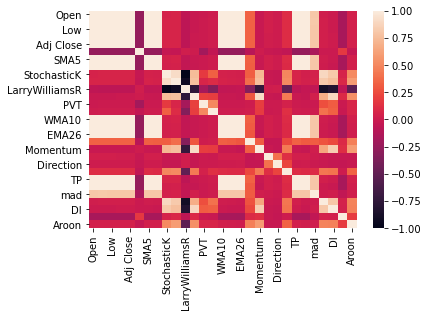

In [38]:
sn.heatmap(corrMatrix, annot=False)
plt.show()

In [39]:
corr_pairs = corrMatrix.unstack()
corr_pairs

Open   Open         1.000000
       High         0.999865
       Low          0.999862
       Close        0.999712
       Adj Close    0.999712
                      ...   
Aroon  mad          0.023858
       CCI          0.482109
       DI           0.472540
       ADX          0.182153
       Aroon        1.000000
Length: 841, dtype: float64

In [40]:
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
sorted_pairs

StochasticK     LarryWilliamsR   -1.000000
LarryWilliamsR  StochasticK      -1.000000
StochasticD     LarryWilliamsR   -0.920396
LarryWilliamsR  StochasticD      -0.920396
CCI             LarryWilliamsR   -0.895844
                                    ...   
sma             sma               1.000000
mad             mad               1.000000
CCI             CCI               1.000000
PVT             PVT               1.000000
Aroon           Aroon             1.000000
Length: 841, dtype: float64

In [41]:
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.5]

print(strong_pairs)

StochasticK     LarryWilliamsR   -1.000000
LarryWilliamsR  StochasticK      -1.000000
StochasticD     LarryWilliamsR   -0.920396
LarryWilliamsR  StochasticD      -0.920396
CCI             LarryWilliamsR   -0.895844
                                    ...   
sma             sma               1.000000
mad             mad               1.000000
CCI             CCI               1.000000
PVT             PVT               1.000000
Aroon           Aroon             1.000000
Length: 241, dtype: float64


In [42]:
# strong_pairs[strong_pairs.index[0][0] == strong_pairs.index[0][1]]

removed_diagonal = [(i, j) for (i, j) in strong_pairs.index if i!=j]
len(removed_diagonal)

212

In [43]:
# # Create correlation matrix
# corr_matrix = complete_data.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool8))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# to_drop

In [44]:
# Find index of feature columns with correlation greater than 0.8

correlated_features = set()
for i in range(len(corrMatrix.columns)):
    for j in range(i):
        if abs(corrMatrix.iloc[i, j]) > 0.8:
            colname = corrMatrix.columns[i]
            correlated_features.add(colname)

In [45]:
correlated_features

{'Adj Close',
 'CCI',
 'Close',
 'DI',
 'EMA12',
 'EMA26',
 'High',
 'LarryWilliamsR',
 'Low',
 'Momentum',
 'SMA10',
 'SMA5',
 'StochasticD',
 'TP',
 'WMA10',
 'mad',
 'sma'}

In [46]:
complete_data = complete_data.drop(labels=correlated_features, axis=1)

In [47]:
complete_data

,Date,Open,Volume,StochasticK,ROC,PVT,ADO,MACD,Change,Direction,RSI,ADX,Aroon
14,6/13/2002,1.104286,2567600,7.110768,-0.064198,-23494.382156,0.694920,-0.019919,-0.096428,0,0.282646,6.531289,-12.0
15,6/14/2002,1.082143,4783800,2.549744,-0.106148,-425995.552875,0.027026,-0.029902,-0.064286,0,0.282646,9.143382,-56.0
16,6/17/2002,1.013571,4855200,1.363726,-0.139334,-316415.461427,0.515149,-0.042512,-0.011429,0,0.282646,19.140010,-60.0
17,6/18/2002,0.938571,10808000,17.582308,-0.153949,-133953.879171,0.176472,-0.052818,0.040715,1,0.381194,27.026513,-64.0
18,6/19/2002,0.911429,5482400,28.022051,-0.156961,245099.906227,0.827589,-0.057043,0.005714,1,0.381194,33.442196,-64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,10/22/2021,651.809998,6179700,98.839008,0.040182,109940.080580,0.901101,16.558775,6.879944,1,0.910010,30.296476,92.0
4890,10/25/2021,663.739990,3833500,92.814518,0.063005,39673.672754,0.590110,18.159400,-3.139953,0,0.675676,30.298693,96.0
4891,10/26/2021,673.760010,2904800,86.568968,0.056681,-13579.691869,0.352043,18.956025,-5.600037,0,0.675676,30.769399,76.0
4892,10/27/2021,669.000000,2276900,77.131758,0.057221,-19073.062682,0.302296,18.917412,11.130005,1,0.675676,31.225713,76.0


In [48]:
target = complete_data['Direction']
complete_data = complete_data.drop(['Date', 'Direction', 'Change'], axis=1)
complete_data

,Open,Volume,StochasticK,ROC,PVT,ADO,MACD,RSI,ADX,Aroon
14,1.104286,2567600,7.110768,-0.064198,-23494.382156,0.694920,-0.019919,0.282646,6.531289,-12.0
15,1.082143,4783800,2.549744,-0.106148,-425995.552875,0.027026,-0.029902,0.282646,9.143382,-56.0
16,1.013571,4855200,1.363726,-0.139334,-316415.461427,0.515149,-0.042512,0.282646,19.140010,-60.0
17,0.938571,10808000,17.582308,-0.153949,-133953.879171,0.176472,-0.052818,0.381194,27.026513,-64.0
18,0.911429,5482400,28.022051,-0.156961,245099.906227,0.827589,-0.057043,0.381194,33.442196,-64.0
...,...,...,...,...,...,...,...,...,...,...
4889,651.809998,6179700,98.839008,0.040182,109940.080580,0.901101,16.558775,0.910010,30.296476,92.0
4890,663.739990,3833500,92.814518,0.063005,39673.672754,0.590110,18.159400,0.675676,30.298693,96.0
4891,673.760010,2904800,86.568968,0.056681,-13579.691869,0.352043,18.956025,0.675676,30.769399,76.0
4892,669.000000,2276900,77.131758,0.057221,-19073.062682,0.302296,18.917412,0.675676,31.225713,76.0


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(complete_data,target,test_size=0.3)

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [85]:
complete_data_scaled = scaler.transform(complete_data)

### Logistic Regression

In [52]:
lr = LogisticRegression(solver='liblinear', multi_class='ovr')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.644808743169399

In [53]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [54]:
lr = LogisticRegression(solver='liblinear', multi_class='ovr')
trained_model_lr = lr.fit(X_train, y_train)
predictions_lr = trained_model_lr.predict(X_test)

Train_accuracy_lr = accuracy_score(y_train,trained_model_lr.predict(X_train))
Test_accuracy_lr = accuracy_score(y_test, predictions_lr)
Confusion_matrix_lr = confusion_matrix(y_test,predictions_lr)

In [55]:
Train_accuracy_lr

0.6428571428571429

In [56]:
Test_accuracy_lr

0.644808743169399

In [57]:
Confusion_matrix_lr

array([[464, 248],
       [272, 480]], dtype=int64)

In [64]:
last100 = complete_data.tail(100)
last100_array = last100.to_numpy()

In [65]:
type(last100_array)

numpy.ndarray

In [86]:
predictions_lr_100 = trained_model_lr.predict(complete_data_scaled)

In [87]:
predictions_lr_100[:500]

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,

In [78]:
predictions_lr[:100]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])

### SVM

In [88]:
svm = SVC(gamma='auto')
trained_model_svm = svm.fit(X_train, y_train)
predictions_svm = trained_model_svm.predict(X_test)

Train_accuracy_svm = accuracy_score(y_train,trained_model_svm.predict(X_train))
Test_accuracy_svm = accuracy_score(y_test, predictions_svm)
Confusion_matrix_svm = confusion_matrix(y_test,predictions_svm)

In [89]:
Train_accuracy_svm

0.6809133489461359

In [90]:
Test_accuracy_svm

0.6311475409836066

In [91]:
Confusion_matrix_svm

array([[458, 254],
       [286, 466]], dtype=int64)

### RandomForest

In [92]:
rf = RandomForestClassifier(n_estimators=10)
trained_model_rf = rf.fit(X_train, y_train)
predictions_rf = trained_model_rf.predict(X_test)

Train_accuracy_rf = accuracy_score(y_train, trained_model_rf.predict(X_train))
Test_accuracy_rf = accuracy_score(y_test, predictions_rf)
Confusion_matrix_rf = confusion_matrix(y_test, predictions_rf)

In [93]:
Train_accuracy_rf

0.9812646370023419

In [94]:
Test_accuracy_rf

0.5717213114754098

In [95]:
Confusion_matrix_rf

array([[465, 247],
       [380, 372]], dtype=int64)

### KNN

In [96]:
knn = KNeighborsClassifier(n_neighbors=5)
trained_model_knn = knn.fit(X_train, y_train)
predictions_knn = trained_model_knn.predict(X_test)

Train_accuracy_knn = accuracy_score(y_train, trained_model_knn.predict(X_train))
Test_accuracy_knn = accuracy_score(y_test, predictions_knn)
Confusion_matrix_knn = confusion_matrix(y_test, predictions_knn)

In [97]:
Train_accuracy_knn

0.7137002341920374

In [98]:
Test_accuracy_knn

0.5532786885245902

In [99]:
Confusion_matrix_knn

array([[408, 304],
       [350, 402]], dtype=int64)

### XGBoost

In [100]:
xgb = XGBClassifier(use_label_encoder=False)
trained_model_xgb = xgb.fit(X_train, y_train)
predictions_xgb = trained_model_xgb.predict(X_test)

Train_accuracy_xgb = accuracy_score(y_train, trained_model_xgb.predict(X_train))
Test_accuracy_xgb = accuracy_score(y_test, predictions_xgb)
Confusion_matrix_xgb = confusion_matrix(y_test, predictions_xgb)

[23:50:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [101]:
Train_accuracy_xgb

0.9947306791569087

In [102]:
Test_accuracy_xgb

0.6161202185792349

In [103]:
Confusion_matrix_xgb

array([[419, 293],
       [269, 483]], dtype=int64)

In [104]:
predictions_xgb_100 = trained_model_xgb.predict(last100)
predictions_xgb_100

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0])

## KFold cross validation
### Basic example

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(LogisticRegression(solver='liblinear',multi_class='ovr'), complete_data, target, cv=10)

In [ ]:
cross_val_score(SVC(gamma='auto'), complete_data, target, cv=10)

In [ ]:
cross_val_score(RandomForestClassifier(n_estimators=5), complete_data, target, cv=10)

In [ ]:
cross_val_score(KNeighborsClassifier(n_neighbors=5), complete_data, target, cv=10)

In [ ]:
cross_val_score(XGBClassifier(use_label_encoder=False), complete_data, target, cv=10)